In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle
from ssm.stats import multivariate_normal_logpdf
from ssm.primitives import hmm_expected_states, hmm_sample
from pylds.lds_messages_interface import info_E_step
from behavenet.fitting.utils import build_data_generator, create_tt_experiment
from behavenet.fitting.utils import add_lab_defaults_to_parser, get_output_session_dir, get_expt_dir
from test_tube import HyperOptArgumentParser
from behavenet.fitting.decoding_grid_search import get_decoding_params

In [19]:
def get_params(strategy, args):

    parser = HyperOptArgumentParser(strategy)

    # most important arguments
    parser.add_argument('--search_type', type=str)  # grid_search, test
    parser.add_argument('--lab_example', type=str)  # musall, steinmetz, datta
    parser.add_argument('--tt_save_path', type=str)
    parser.add_argument('--data_dir', type=str)
    parser.add_argument('--model_type', default='ff', choices=['ff', 'ff-mv', 'linear', 'linear-mv', 'lstm'], type=str)
    parser.add_argument('--model_class', default='neural-ae', choices=['neural-ae', 'neural-arhmm', 'ae-neural', 'arhmm-neural'], type=str)
    parser.add_argument('--sessions_csv', default='', type=str, help='specify multiple sessions')

    # arguments for computing resources (infer n_gpu_workers from visible gpus)
    parser.add_argument('--tt_n_gpu_trials', default=1000, type=int)
    parser.add_argument('--tt_n_cpu_trials', default=100000, type=int)
    parser.add_argument('--tt_n_cpu_workers', default=5, type=int)
    parser.add_argument('--mem_limit_gb', default=8.0, type=float)
    parser.add_argument('--gpus_viz', default='0;1', type=str)

    # add data generator arguments
    parser.add_argument('--reg_list', default='none', type=str, choices=['none', 'arg', 'all'])
    parser.add_argument('--subsample_regions', default='none', choices=['none', 'single', 'loo'])
    parser.add_argument('--device', default='cuda', type=str)
    parser.add_argument('--as_numpy', action='store_true', default=False)
    parser.add_argument('--batch_load', action='store_true', default=False)
    parser.add_argument('--rng_seed', default=0, type=int)

    # add fitting arguments
    parser.add_argument('--val_check_interval', default=1)

    # get lab-specific arguments
    namespace, extra = parser.parse_known_args(args)
    add_lab_defaults_to_parser(parser, namespace.lab_example)
    namespace, extra = parser.parse_known_args(args)  # ugly

    # add regions to opt_list if desired
    if namespace.reg_list == 'all':
        parser.opt_list('--region', options=get_region_list(namespace), type=str, tunable=True)
    elif namespace.reg_list == 'arg':
        parser.add_argument('--region', default='all', type=str)
    elif namespace.reg_list == 'none':  # TODO: fix this ambiguity
        parser.add_argument('--region', default='all', type=str)
    else:
        raise ValueError(
            '"%s" is not a valid region_list' % namespace.region_list)

    get_decoding_params(namespace, parser)

    return parser.parse_args(args)

In [22]:
command_line_arg = '--search_type test --lab_example musall --animal mSM36 --session 05-Dec-2017 --tt_save_path /media/gssda/behavenet/results/ --data_dir /media/gssda/behavenet/data/  --model_type ff --model_class neural-ae --experiment_name grid_search --export_predictions --ae_experiment_name ae-dim-test --ae_model_type conv --n_ae_latents 8 --min_n_epochs 10 --max_n_epochs 500 --device cpu --n_lags 4 --l2_reg 1e-4 --n_hid_layers 3 --ae_multisession 0 --subsample_regions single --region ACAd1'
hparams = get_params('grid_search', command_line_arg.split(' '))
hparams = vars(hparams)
hparams.pop('trials', False)
hparams.pop('generate_trials', False)
hparams.pop('optimize_parallel', False)
hparams.pop('optimize_parallel_cpu', False)
hparams.pop('optimize_parallel_gpu', False)
hparams.pop('optimize_trials_parallel_gpu', False)

# create test-tube experiment
#hparams, sess_ids, exp = create_tt_experiment(hparams)
hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
hparams['expt_dir'] = 'temp/'
hparams['version'] = 0
# build data generator
ae_data_generator = build_data_generator(hparams, sess_ids)


using data from following sessions:
/media/gssda/behavenet/results/musall/vistrained/mSM36/05-Dec-2017
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
	signals: ['neural', 'ae_latents']
	transforms: [Compose(SelectIndxs(sample_name=ACAd1-single), ZScore()), None]
	paths: ['/media/gssda/behavenet/data/musall/vistrained/mSM36/05-Dec-2017/data.hdf5', '/media/gssda/behavenet/results/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1/latents.pkl']




In [6]:
rr = ae_data_generator.next_batch('train')

In [7]:
rr[0]['neural'].shape


torch.Size([1, 189, 258])

In [11]:
rr

({'neural': tensor([[[ 0.3500, -1.3121,  0.9094,  ...,  1.7364,  1.1408,  1.0782],
           [-1.5193, -0.9362,  0.3275,  ..., -0.0321,  0.7345,  0.4263],
           [-0.3199, -1.9528,  0.1025,  ...,  3.3824,  1.6715,  1.3395],
           ...,
           [-0.1495,  0.8736,  0.6019,  ...,  0.4206, -0.7944, -0.1859],
           [-0.1188,  0.7206, -0.3846,  ...,  0.3049, -1.2505, -1.8638],
           [ 0.5063,  0.5157, -0.2403,  ...,  1.5850, -1.7116,  0.1606]]]),
  'ae_latents': tensor([[[-0.8534,  2.6596, -0.2785,  ..., -2.0498, -0.5763,  2.2216],
           [-0.7799,  1.4893,  0.7264,  ..., -1.9227, -1.5940,  1.6035],
           [-1.2754,  2.4082,  0.3770,  ..., -2.0522, -1.3287,  1.9214],
           ...,
           [ 2.3841,  1.3292, -0.3537,  ..., -1.7948,  0.8444, -0.4419],
           [ 2.6230,  0.9644, -0.1626,  ..., -1.2334,  0.9186, -0.6382],
           [ 2.3687,  0.7670,  0.7165,  ..., -0.4218,  1.0186, -0.5224]]]),
  'batch_indx': tensor([19])},
 0)

(-4, 3)

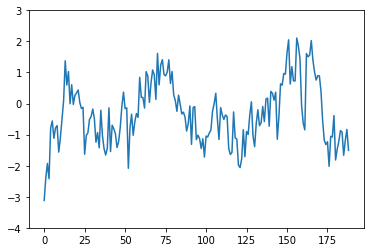

In [24]:
plt.plot(ae_data_generator.datasets[0][19]['neural'][:,10].cpu().detach().numpy());
plt.ylim([-4,3])

In [7]:
from behavenet.data.utils import get_region_list
ll = get_region_list(hparams)

In [49]:
[i.shape for i in ll.values()]

[(15,),
 (11,),
 (18,),
 (23,),
 (13,),
 (28,),
 (14,),
 (26,),
 (45,),
 (14,),
 (6,),
 (45,)]

In [51]:
ll.keys()

dict_keys(['ACAd1', 'AUD', 'FRP1', 'MOB', 'MOp', 'MOs', 'PL1', 'RSP', 'SSp', 'SSs1', 'TEa1', 'VIS'])

In [50]:
15+11+18+23+13+28+14+26+45+14+6+45

258

In [4]:
# command_line_arg = '--search_type test --lab_example musall --animal mSM36 --session 05-Dec-2017 --tt_save_path /media/gssda/behavenet/results/ --data_dir /media/gssda/behavenet/data/ --model_type ff --model_class neural-arhmm --experiment_name grid_search --n_ae_latents 8 --arhmm_experiment_name grid_search --n_arhmm_states 8 --kappa 0 --noise_type gaussian --min_n_epochs 10 --max_n_epochs 500 --n_lags 4 --l2_reg 1e-4 --n_hid_layers 1 --arhmm_multisession 0 --device cpu'
# hparams = get_params('grid_search', command_line_arg.split(' '))
# hparams = vars(hparams)
# hparams.pop('trials', False)
# hparams.pop('generate_trials', False)
# hparams.pop('optimize_parallel', False)
# hparams.pop('optimize_parallel_cpu', False)
# hparams.pop('optimize_parallel_gpu', False)
# hparams.pop('optimize_trials_parallel_gpu', False)

# # create test-tube experiment
# #hparams, sess_ids, exp = create_tt_experiment(hparams)
# hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
# hparams['expt_dir'] = 'temp/'
# hparams['version'] = 0
# # build data generator
# arhmm_data_generator = build_data_generator(hparams, sess_ids)


In [5]:
# N = 545
# K = 8

# ae_neural = [None for i in range(N)]
# ae_latents = [None for i in range(N)]
# arhmm_neural = [None for i in range(N)]
# arhmm_states = [None for i in range(N)]

# for ii in range(ae_data_generator.n_tot_batches['train']):
#     ae_data, _ = ae_data_generator.next_batch('train')
#     arhmm_data, _ = arhmm_data_generator.next_batch('train')
    
#     ae_neural[ae_data['batch_indx'].item()] = ae_data['neural'].cpu().detach().numpy().squeeze()
#     ae_latents[ae_data['batch_indx'].item()] = ae_data['ae_latents'].cpu().detach().numpy().squeeze()
    
#     arhmm_neural[arhmm_data['batch_indx'].item()] = arhmm_data['neural'].cpu().detach().numpy().squeeze()
#     arhmm_states[arhmm_data['batch_indx'].item()] = arhmm_data['arhmm_states'].cpu().detach().numpy().squeeze()
    
# neural = [v for v in ae_neural if v is not None]
# xs = [v for v in ae_latents if v is not None]
# zs = [v for v in arhmm_states if v is not None]


In [6]:
#np.savez('arhmm_decoding_data.npz',neural=neural, latents=xs, states=zs)

In [7]:
data = np.load('arhmm_decoding_data.npz')
neural = data['neural']
xs = data['latents']
zs = data['states']

In [8]:
# Have to lag the neural activity for each batch

W = 8
N = neural[0].shape[1]

ns_window = [_ for i in range(len(neural))]
for i in range(len(neural)):
    T = neural[i].shape[0]
    neural_pad = np.concatenate([np.zeros((W//2, N)), neural[i], np.zeros((W//2, N))])
    ns_window[i] = np.column_stack([neural_pad[w:T+w] for w in range(W)] )


In [28]:
ns_window_flat.shape

(10000, 2064)

In [9]:
# Concatente into sequences, take only part for now
T=10000
ns_window_flat =np.concatenate(ns_window,axis=0)[:T]
zs_flat = np.concatenate(zs,axis=0)[:T]
xs_flat = np.concatenate(xs,axis=0)[:T]

In [10]:
# Logistic regression

recog_z = LogisticRegression(solver='lbfgs', max_iter=1000)
recog_z.fit(ns_window_flat, zs_flat)


/Users/scott/miniconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# Linear regression

recog_x = LinearRegression()
recog_x.fit(ns_window_flat, xs_flat)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Load in ARHMM model and get parameters
D=8
arhmm_model = pickle.load(open('best_val_model.pt','rb'))

K = arhmm_model.K
P = arhmm_model.transitions.transition_matrix
As = arhmm_model.observations.As
bs = arhmm_model.observations.bs
Qs = arhmm_model.observations.Sigmas

evals, evecs = np.linalg.eig(P.T)
perm = np.argsort(evals)[::-1]
evals, evecs = evals[perm], evecs[:, perm]
assert np.allclose(evals[0], 1.0)
if np.any(evecs[:,0] <= 0):
    evecs[:,0] = -1*evecs[:,0]
assert np.all(evecs[:,0] >= 0) 
pz_infty = np.real(evecs[:, 0] / evecs[:, 0].sum())

In [91]:
mu_infty = np.zeros((K, D))
Sigma_infty = np.zeros((K, D, D))
for k in range(K):
    mu_infty[k] = np.mean(xs_flat[zs_flat == k],axis=0)
#     Sigma_infty[k] = np.cov(training_ae[training_arhmm == k].T)
    Sigma_infty[k] = np.cov(xs_flat.T)
    
mu0 = np.zeros(D)
Sigma0 = np.eye(D)

In [236]:
# Use the information form.  It will generalize better to VI.
from pylds.lds_messages_interface import info_E_step

# Compute the info potentials for the initial condition
def _info_params(mu0, Sigma0, As, bs, Qs, q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample):
    # parameter checking
    T, K = Ez.shape
    assert As.shape[0] == K and As.ndim == 3 and As.shape[1] == As.shape[2]
    D = As.shape[1]
    assert mu0.shape == (D,)
    assert Sigma0.shape == (D, D)
    assert bs.shape == (K, D)
    assert Qs.shape == (K, D, D)
    assert q_mu_x.shape == (T, D)
    assert q_Sigma_x.shape == (D, D)
    
    # Make pseudo-inputs (all ones) for bias terms
    inputs = np.ones((T, 1))
    
    # Convert initial distribution to info form
    # (ignore normalizing constants)
    J0 = np.linalg.inv(Sigma0)
    h0 = J0 @ mu0
    log_Z0 = 0

    # Info dynamics parameters
    J_pair_22 = np.linalg.inv(Qs)
    J_pair_21 = -np.matmul(np.linalg.inv(Qs), As)
    J_pair_11 = np.matmul(np.swapaxes(As, 1, 2), -J_pair_21)
    mBTQiA = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_21)
    BTQi = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_22)

    # Get expected sufficient statistics by integrating over z
    J_pair_22 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_22)
    J_pair_21 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_21)
    J_pair_11 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_11)
    mBTQiA = np.einsum('tk, kij -> tij', Ez[:-1], mBTQiA)
    BTQi = np.einsum('tk, kij -> tij', Ez[:-1], BTQi)
    h_pair_1 = np.einsum('tu, tud -> td', inputs[:-1], mBTQiA)
    h_pair_2 = np.einsum('tu, tud -> td', inputs[:-1], BTQi)
    log_Z_pair = np.zeros(T-1)

    # Info emission parameters
    J_obs = (np.linalg.inv(q_Sigma_x) - np.linalg.inv(Sigma_infty))[z_sample]
    assert np.all(np.linalg.eigvalsh(J_obs[0])) >= 0
    h_recog = np.dot(np.linalg.inv(q_Sigma_x), q_mu_x.T).T
    h_infty = np.linalg.solve(Sigma_infty, mu_infty)[z_sample]
    h_obs = h_recog - h_infty
    log_Z_obs = np.zeros(T)
    
    return J0, h0, log_Z0, \
           J_pair_11, J_pair_21, J_pair_22, h_pair_1, h_pair_2, log_Z_pair, \
           J_obs, h_obs, log_Z_obs


In [238]:
# Initialize q(z) with just the learned recognition potential
log_qzs = [recog_z.predict_log_proba(nsw) for nsw in ns_window]
q_mu_xs = [recog_x.predict(nsw) for nsw in ns_window]

In [325]:
# Get the covariance over all trials
q_Sigma_x = 1.0 * np.cov((np.vstack(xs[:50]) - np.vstack(q_mu_xs[:50])).T)

# Extract one trial's predictions
t = 150 # which batch to use 
q_mu_x = q_mu_xs[t]
log_qz = log_qzs[t]

In [352]:
n_iter = 0

# initialize z with only the recognition potential
z_potential = log_qz - np.log(pz_infty)
Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
z_sample = hmm_sample(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

# get Ex for the initial z's
args = _info_params(mu0, Sigma0, As, bs, Qs, 
                    q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample)

# J_obs, h_obs = args[-3], args[-2]
# mu_obs = np.linalg.solve(J_obs, h_obs)

_, Ex, Covx, _ = info_E_step(*args)
stdx = np.sqrt(Covx[:, np.arange(D), np.arange(D)])

In [353]:
Covx[:, np.arange(D), np.arange(D)].min()

0.001569664395432347

In [346]:
for i in range(n_iter):
    # Update z, now including the dynamics potential
    # 
    # q(z) \propto \exp{ E_{q(x)} [log p(z, x)] }
    # 
    # we want E_{q(x)} log p(x | z) but we're currently using log p(E_{q(x)}[x] | z)
    
    # TODO: Should really include the covariance of x in this update too
    z_dyn_potential = np.column_stack(
        [multivariate_normal_logpdf(Ex[1:], Ex[:-1] @ A.T + b, Q) 
         for A, b, Q in zip(As, bs, Qs)])
    z_dyn_potential = np.row_stack((np.zeros(K), z_dyn_potential))
    z_potential = log_qz - np.log(pz_infty) + z_dyn_potential
    Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
    z_sample = hmm_sample(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
    
    # compute the expected value of x given z and the observation potential
    _, Ex, _, _ = info_E_step(
        *_info_params(mu0, Sigma0, As, bs, Qs, 
                      q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez, z_sample))

    #print(np.unique(Ez))
    print("MSE: ", np.mean((Ex[:,:D] - xs[t])**2))

In [ ]:
# Compute the covariance of x

In [327]:
print(np.mean((q_mu_x - xs[t])**2))
print(np.mean((Ex - xs[t])**2))

0.7090622393421787
0.645238141137439


In [328]:
sampled_observations = np.zeros((len(zs[t]),D))
for i_t in range(len(zs[t])):
    sampled_observations[i_t] = arhmm_model.observations.sample_x(np.argmax(Ez,axis=1)[i_t], sampled_observations[:i_t], input=[0], with_noise=False)
    
    

In [369]:
Ez_behavior, _, _ = arhmm_model.expected_states(xs[t])

In [370]:
Ez_behavior.shape

(189, 8)

Text(0.5, 0, 'time')

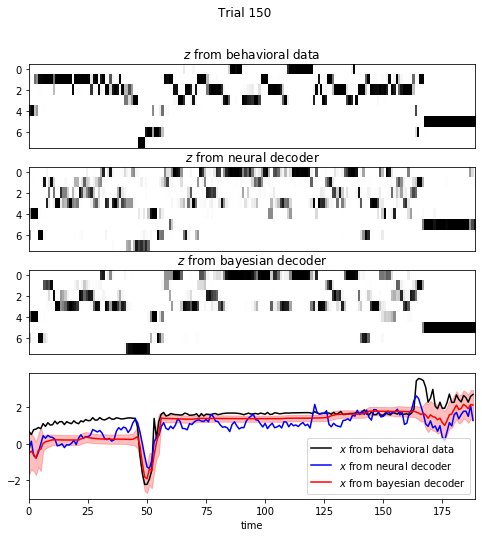

In [371]:
plt.figure(figsize=(8, 8))
gs = GridSpec (4, 1, height_ratios=[1,1,1,1.5])

plt.suptitle("Trial {}".format(t))
plt.subplot(gs[0])
# plt.imshow((zs[t][:, None] == np.arange(K)).T, cmap="Greys", aspect="auto", vmin=0, vmax=1)
plt.imshow(Ez_behavior.T, cmap="Greys", aspect="auto", vmin=0, vmax=1)
plt.xticks([])
plt.title("$z$ from behavioral data")

plt.subplot(gs[1])
plt.imshow(np.exp(log_qz).T, cmap="Greys", aspect="auto", vmin=0, vmax=1)
plt.xticks([])
plt.title("$z$ from neural decoder")

plt.subplot(gs[2])
plt.imshow(Ez.T, cmap="Greys", aspect="auto", vmin=0, vmax=1)
plt.xticks([])
plt.title("$z$ from bayesian decoder")

plt.subplot(gs[3])
plt.plot(xs[t][:,0],'k', label="$x$ from behavioral data")
plt.plot(q_mu_x[:,0],'b', label="$x$ from neural decoder")
plt.fill_between(np.arange(Ex.shape[0]), 
                 Ex[:, 0] - 3 * stdx[:, 0], 
                 Ex[:, 0] + 3 * stdx[: ,0], color='r', alpha=0.25)
plt.plot(Ex[:,0],'r', label="$x$ from bayesian decoder")
plt.legend(loc="lower right")
plt.xlim(0, Ex.shape[0])
plt.xlabel("time")
# # plt.plot(mu_obs[:, 0])
# # plt.plot(np.zeros(xs[t].shape[0]), ":k")
# # plt.plot(sampled_observations[:,0],'g')
# plt.legend()
# plt.legend(['Real Latents', 'Decoded latents', 'After VI', 'Conditionally sampled latents'])